<h1> Sales forecast example </h1>

<h3>Intro</h3>
Forecasting is a process of making predictions of the future based on past data and trends. In this example we will be using real, anonymized retail sales data. The original dataset can be found <a href="https://www.kaggle.com/datasets/manjeetsingh/retaildataset?select=sales+data-set.csv">here</a>. It contains roughly 2 years of data for multiple stores and departments. For the purpose of this example we will be focusing on a single store & department.

We will be using <a href="https://facebook.github.io/prophet/">Prophet</a> - a procedure for forecasting time series data developed by Facebook. First, we need to import the necessary libraries:

In [25]:
import pandas as pd
import numpy as np
import openpyxl
import datetime
from matplotlib import pyplot
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

<h3>Loading and cleaning data</h3>

Next, we load the dataset into a Pandas dataframe for easy manipulation, and we perform some basic cleaning tasks: we keep only the necessary columns and ensure that the types are correct. Prophet requires a dataset containing specific column names (ds, y), so we take care of that as well. Finally, a plot of the dataset is displayed for a fast validtion.

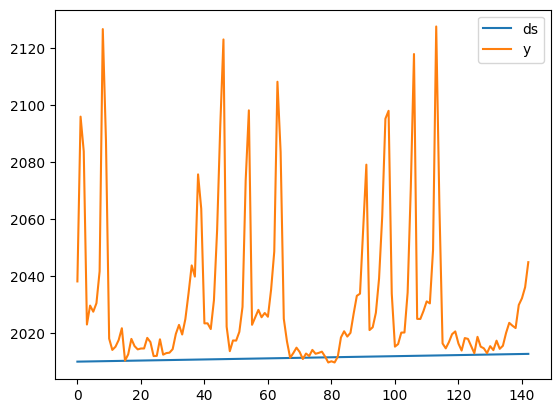

In [13]:
# Data cleaning
raw_df = pd.read_csv('kaggle_sales.csv')

# Pick the target columns
df = raw_df.query('Store==1 & Dept==1 ')
df = df.iloc[:, [2, 3]]
df.columns =['date', 'volume']

df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df['volume'] = df['volume'].astype('int').abs()

series = (
    df.sort_values(["date"], ascending=True)
    .rename(columns={"date": "ds", "volume": "y"})
)

series.plot()
pyplot.show()

<h3>Developing the model</h3>

Next, we develop and fit the forecast model. In this particular case it is pretty straightforward - but many parameters can be adjusted accordingly as needed in real use cases.

In [10]:
# Fit model
m = Prophet(changepoint_prior_scale = 0.9)
m.fit(series)

21:45:16 - cmdstanpy - INFO - Chain [1] start processing
21:45:17 - cmdstanpy - INFO - Chain [1] done processing


<h3>Making a prediction</h3>

Predictions are then made on a weekly basis. We define a prediction over 52 weeks, which roughly corresponds to a year.

          ds          yhat    yhat_lower    yhat_upper
0 2010-02-05  32106.187404  24549.881997  39539.855716
1 2010-02-12  38067.974498  30769.341435  45570.948036
2 2010-02-19  36757.298956  29665.911356  44260.046766
3 2010-02-26  28869.742534  21210.660999  36130.571481
4 2010-03-05  19869.967949  12238.364230  27664.035734


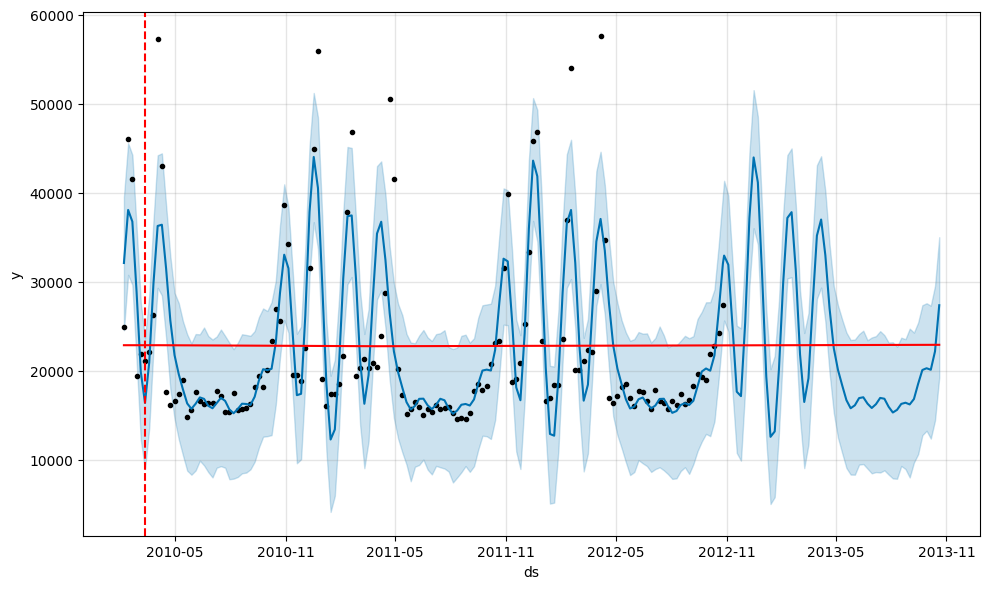

In [14]:
# Make a prediction
future = m.make_future_dataframe(periods=52, freq='W')

# Summarize forecast
forecast = m.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# Plot forecast
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

<h3>Understanding forecast components</h3>

Next, we plot various forecast components, such as trend and seasonality. More can be found <a href="https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html">here</a>

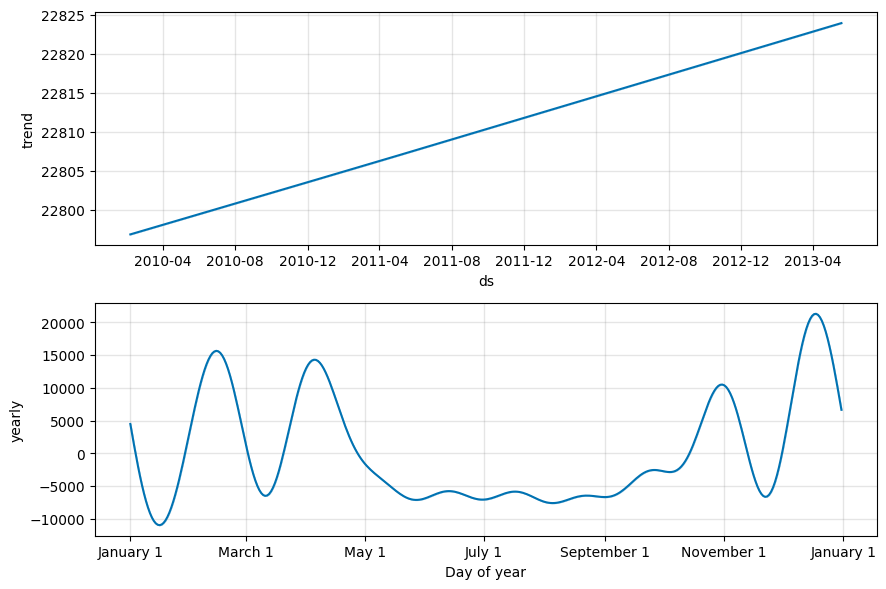

In [6]:
# Plot forecast components
m.plot_components(forecast)
pyplot.show()

<h3>Assessing performance</h3>

Prophet includes functionality for time series cross-validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point.

Here we do cross-validation to assess prediction performance on a horizon of a year. More on how to assess model performance can be found <a href="https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation">here</a>.

  0%|          | 0/8 [00:00<?, ?it/s]

22:25:40 - cmdstanpy - INFO - Chain [1] start processing
22:25:41 - cmdstanpy - INFO - Chain [1] done processing
22:25:42 - cmdstanpy - INFO - Chain [1] start processing
22:25:43 - cmdstanpy - INFO - Chain [1] done processing
22:25:43 - cmdstanpy - INFO - Chain [1] start processing
22:25:45 - cmdstanpy - INFO - Chain [1] done processing
22:25:46 - cmdstanpy - INFO - Chain [1] start processing
22:25:47 - cmdstanpy - INFO - Chain [1] done processing
22:25:48 - cmdstanpy - INFO - Chain [1] start processing
22:25:49 - cmdstanpy - INFO - Chain [1] done processing
22:25:50 - cmdstanpy - INFO - Chain [1] start processing
22:25:50 - cmdstanpy - INFO - Chain [1] done processing
22:25:51 - cmdstanpy - INFO - Chain [1] start processing
22:25:51 - cmdstanpy - INFO - Chain [1] done processing
22:25:52 - cmdstanpy - INFO - Chain [1] start processing
22:25:53 - cmdstanpy - INFO - Chain [1] done processing


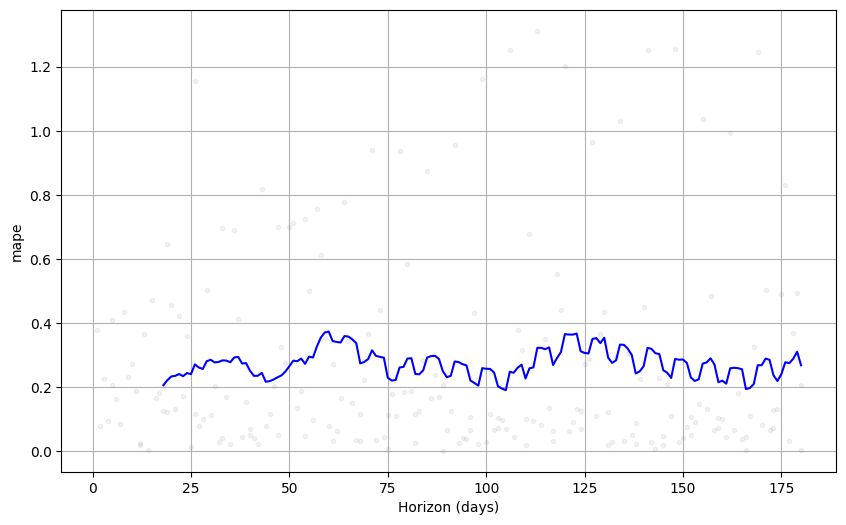

In [24]:
# Assess performance - MAPE (Mean Absolute Percentage Error)
df_cv = cross_validation(m, initial='365.25 days', period='60 days', horizon = '180 days')
df_p = performance_metrics(df_cv)
fig_p = plot_cross_validation_metric(df_cv, metric='mape')

<h3>Conclusion</h3>

Even with a limited dataset and very simple application of the algorithm, a result of MAPE below 0.5 is generally considered a good prediction!